In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy
from models import GNN_A3TGCN_ea
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric import seed_everything

In [3]:
trafo_id = "T1330"
epochs = 1
num_timesteps_in = 12
num_timesteps_out = 4
test_ratio_vs_eval_ratio = 0.5
learning_rate = 0.01
device_str = 'cpu'
hidden = 64
manual_seed = 42

In [4]:
if device_str == 'cuda':
    torch.cuda.empty_cache()

In [5]:
seed_everything(manual_seed)

In [6]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy_cut(loader_data_index)
eval_dataset, test_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
Voltage index: 5
 done


In [8]:
def train_eval(model, loader, device, train_dataset, eval_dataset, optimizer, loss_fn, scheduler=None, epochs=10, name=""):
    """
    Definition of the training loop.
    """
    epoch_losses_train = []
    epoch_losses_eval = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss_train = 0

        for snapshot_i in tqdm(train_dataset, desc="Training epoch {}".format(epoch)):
            snapshot = loader.get_snapshot(snapshot_i)
            snapshot.to(device)
            optimizer.zero_grad()

            out = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss = loss_fn()(out, snapshot.y)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.detach().cpu().numpy()

        if scheduler is not None:
            scheduler.step(epoch_loss_train)

        epoch_losses_train.append(epoch_loss_train)

        model.eval()
        epoch_loss_eval = 0
        with torch.no_grad():

            for snapshot_j in tqdm(eval_dataset, desc="Evaluating epoch {}".format(epoch)):
                snapshot = loader.get_snapshot(snapshot_j)
                snapshot.to(device)

                out = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)

                loss = loss_fn()(out, snapshot.y).cpu().numpy()
                epoch_loss_eval += loss

            epoch_losses_eval.append(epoch_loss_eval)
            if min(epoch_losses_eval) == epoch_loss_eval:
                torch.save(model.state_dict(), name)
            print("Epoch: {}, Train Loss: {:.7f}, Eval Loss: {:.7f}".format(epoch, epoch_loss_train, epoch_loss_eval))
        
        
    return epoch_losses_train, epoch_losses_eval

In [10]:
device = torch.device(device_str)
model = GNN_A3TGCN_ea(node_features=loader.num_features, edge_features=loader.num_edge_features, periods=num_timesteps_out, hidden=hidden).to(device)



#get dateime string of now
now = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

name = f"../models/final/{model.name}_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-1month_lr-{learning_rate}_hidden-{hidden}.pt"
name_txt = f"../models/final/{model.name}_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-1month_lr-{learning_rate}_hidden-{hidden}.txt"


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
losses_train, losses_eval = train_eval(model, loader, device, train_dataset, eval_dataset, optimizer, loss_fn, scheduler=scheduler, epochs=epochs, name=name)


Evaluating epoch 0: 100%|██████████| 1440/1440 [00:22<00:00, 63.90it/s]

Epoch: 0, Train Loss: 702.7101791, Eval Loss: 6468.6770682


In [11]:
std = loader.mean_and_std["measurements"][1]["voltage"]
mean = loader.mean_and_std["measurements"][0]["voltage"]

In [12]:
def eval(model, loader, test_dataset, device, loss_fn, std, mean):
    preds = []
    ys = []
    with torch.no_grad():
        model.eval()
        loss_all = 0
        loss_elementwise = 0
        
        for snapshot_j in tqdm(test_dataset, desc="Evaluating"):
            snapshot = loader.get_snapshot(snapshot_j)
            snapshot = snapshot.to(device)
            
            out= model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)

            loss_all += loss_fn()(out, snapshot.y).cpu().numpy()
            loss_elementwise += loss_fn(reduction="none")(out, snapshot.y).cpu().numpy()

            ys.append(snapshot.y.cpu().numpy()*std+mean)
            preds.append(out.cpu().numpy()*std+mean)
            
        loss_all *= std/len(test_dataset)
        loss_elementwise *= std/len(test_dataset)

        ys = np.stack(ys, axis=-1)
        preds = np.stack(preds, axis=-1)
    return loss_all, loss_elementwise, preds, ys

In [13]:
model.load_state_dict(torch.load(name))

<All keys matched successfully>

In [14]:
loss_fn = torch.nn.L1Loss

In [15]:
loss_test, loss_test_elementwise, preds, ys = eval(model, loader, test_dataset, device, loss_fn, std, mean)
loss_test_timewise = loss_test_elementwise.mean(axis=0)
print("Loss all: {:.7f}".format(loss_test))
print("Loss elementwise: {}".format(loss_test_elementwise))

Evaluating:   0%|          | 0/1440 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1440/1440 [00:27<00:00, 52.39it/s]

Loss all: 6.2759485
Loss elementwise: [[ 3.06945    3.1010113  3.1918688  3.1417212]
 [ 5.368548   5.9331107  6.1739044  7.058126 ]
 [ 5.368548   5.9331107  6.1739044  7.058126 ]
 [ 5.368548   5.9331107  6.1739044  7.058126 ]
 [ 5.368548   5.9331107  6.1739044  7.058126 ]
 [ 5.368548   5.9331107  6.1739044  7.058126 ]
 [ 5.368548   5.9331107  6.1739044  7.058126 ]
 [ 5.368548   5.9331107  6.1739044  7.058126 ]
 [ 3.2211347  3.7324038  4.0918965  4.8277736]
 [ 4.966271   5.5649614  5.863911   6.7877383]
 [ 4.749889   5.33871    5.6312304  6.5396986]
 [ 4.685986   5.2430644  5.490232   6.362887 ]
 [ 3.2390652  3.863944   4.298637   5.212339 ]
 [ 4.5868506  5.143472   5.3986893  6.2664485]
 [ 3.0208714  3.5366716  3.9077132  4.6456656]
 [ 4.6050615  5.1621757  5.4166913  6.2851214]
 [ 4.4672666  5.020686   5.2810507  6.141651 ]
 [ 4.9536757  5.536946   5.830932   6.7317343]
 [ 3.2053738  3.724171   4.1283274  4.8817077]
 [ 5.315594   5.868273   6.0910816  6.9640217]
 [ 3.0681965  3.588875

In [16]:
import matplotlib.pyplot as plt

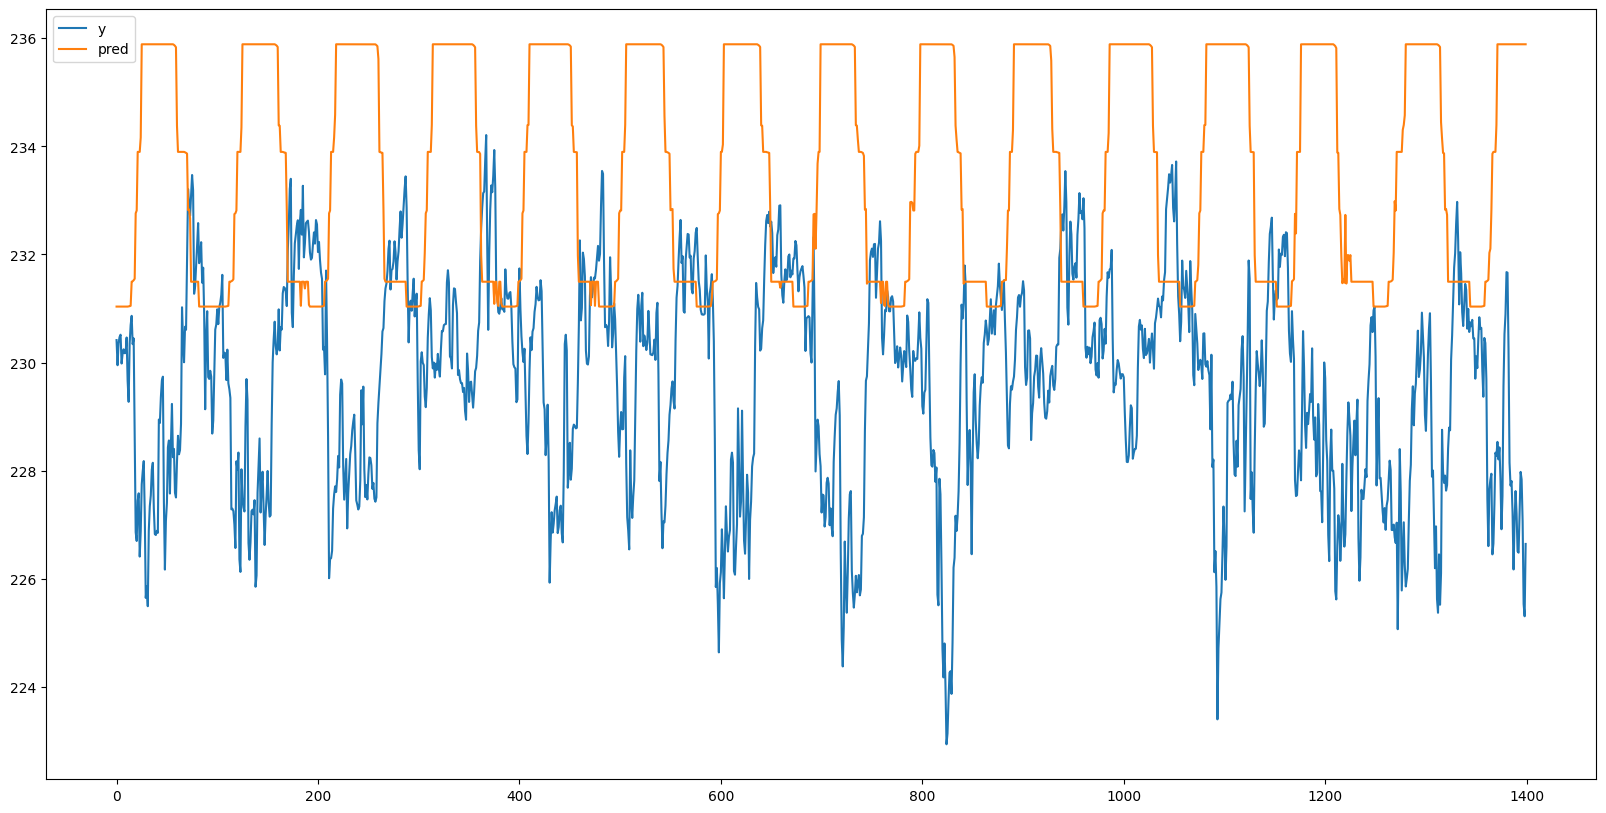

In [17]:
node = 50
pred_ind = 0

start = 0
len_measurements = 1400

plt.figure(figsize=(20,10))
plt.plot(ys[node,pred_ind,start:start+len_measurements], label="y")
plt.plot(preds[node,pred_ind,start:start+len_measurements], label="pred")
plt.legend()

In [15]:
#create txt file at name_txt
with open(name_txt, "w") as f:
    #print losses
    f.write("train losses:\n")
    f.write(str(losses_train))
    f.write("\n")
    f.write("eval losses:\n")
    f.write(str(losses_eval))
    f.write("\n")
    f.write("test loss:\n")
    f.write(str(loss_test))
    f.write("\n")
    f.write(str(loss_test_timewise))
    f.write("\n")
    f.write(str(loss_test_elementwise))
    f.write("\n")